''Stoke's Sinker''
======

Demonstration tutorial for setting up particle swarms with different material properties. This system consists of a dense, high viscosity sphere falling through a background lower density and viscosity fluid. 

**This lesson introduces the concepts of:**
1. creating particle swarms
2. associating different materials with different particle swarms
3. using the ``branching.conditional`` function in underworld
4. advecting particle swarms in a Stokes system

**Keywords:** particle swarms, Stokes system, advective diffusive systems


Load python functions needed for underworld.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt

Import ``numpy`` and ``matplotlib`` for simple plotting. The first command below is a ``python magic`` which flags to ``matplotlib`` to output any plots to the screen, specifically to the ipython notebook output cell. ``matplotlib`` also contains ``pylab`` which is useful for resizing the output figure on screen.

In [2]:
%matplotlib inline
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
import numpy as np

Setup parameters
-----

Set simulation parameters for the test and position of the spherical sinker.

In [3]:
dim = 2
boxHeight = 1.0
boxLength = 0.9142

# set the resolution
res = 64

# set size and position of dense sphere
sphereRadius = 0.1
sphereCentre = (0.5*boxLength, 0.7*boxHeight)

Create mesh and finite element variables
------

In [4]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (boxLength, boxHeight))
velocityMesh    = elementMesh
pressureMesh    = elementMesh.subMesh 

velocityField    = uw.fevariable.FeVariable( feMesh=velocityMesh, nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=pressureMesh, nodeDofCount=1 )

Set initial conditions and boundary conditions
----------

**Initial and boundary conditions**

Create the initial conditions for the fluid finite element fields. The initial conditions for the particle swarms, which are more important here, are set below.

In [5]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls to define conditons for underworld solvers.

In [6]:
iWalls = velocityMesh.specialSets["MinI_VertexSet"] + velocityMesh.specialSets["MaxI_VertexSet"]
jWalls = velocityMesh.specialSets["MinJ_VertexSet"] + velocityMesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               nodeIndexSets = (iWalls, jWalls) )

Create a particle swarm
------

Swarms refer to (large) groups of particles which can advect with the fluid flow. These can be used to determine 'materials' as they can carry local information such as the fluid density and viscosity.

Underworld uses these when the local fluid density is calculated on the mesh, which in turn affects the fluid velocity, and subsequently the advection of the particle swarm.

**Setup a swarm**

To set up a swarm of particles the following steps are needed:
1. initialise and name a swarm, here called ``swarm``
2. define data variable (``materialIndex``) to store an index that will state what material a given particle is
3. populate the swarm over the whole domain using the layout command, here this is used to allocate 20 particles in each grid cell
4. indicate to underworld that this swarm of particles is active

In [7]:
# initialise a swarm. Note this must be the whole mesh, i.e. elementMesh.
swarm = uw.swarm.Swarm( feMesh=elementMesh )

# add a data variable which will store an index to determine material
materialIndex = swarm.add_variable( dataType="int", count=1 )

# create a layout object that will populate the swarm across the whole domain
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )

# activate the layout object
swarm.populate_using_layout( layout=swarmLayout )

**Create a tracer swarm**

Add a ``tracer swarm`` which consists of a single particle placed somewhere in the flow which we would like to track over time. In this case the centre of the dropping sphere. This allows us to plot the motion of the sphere over time.

In [8]:
# setup a new swarm
tracerSwarm = uw.swarm.Swarm( feMesh=elementMesh )

# setup an array containing the position data from the centre of the sphere
particleCoordinates = np.zeros((1,2))     # 1 is for the number of particles,
                                          # 2 for the number of dimensions for the position
particleCoordinates[0] = sphereCentre    # copy position data for the sphere into the newly created array

# use this array to add particles to the new swarm
tracerSwarm.add_particles_with_coordinates(particleCoordinates)


array([0], dtype=int32)

**Define a shape**

Define a python function that mathematically describes a shape, in this case a circle offset to the centre of the sinker. Note that this returns an underworld function, which can be used in the branching condition function below.

In [9]:
def circleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2

**Set material index for each swarm particle**

Use the location of each particle (stored in the 2 dimensional vector called ``coord``) to set the material type. In this case the circle function defined above will return ``True`` when the ``coord`` is within the circular sinker and ``False`` otherwise. The branching conditional function will then set the ``materialIndex`` data value for that particle to equal the ``materialHeavyIndex`` if it is inside the sinker, or the ``materialLightIndex`` otherwise.

In [10]:
# Lets initialise the 'materialVariable' data to represent two different materials. 
materialLightIndex = 0
materialHeavyIndex = 1

# create a circle (our central sphere in 2D)
coord = fn.input()

# set up the condition for being in a circle. if not in sphere then will return light index
conditions = [ ( circleFnGenerator( sphereCentre, sphereRadius) , materialHeavyIndex), 
               ( True                                           , materialLightIndex) ]

# use the branching conditional function to set each particle's material index
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

**Branching conditional function**

The material index is set using a underworld function called 'branching.conditional' which has the form of:

    if( [ (condition function 1, action function 1), 
          (condition function 2, action function 2), 
          ... 
          (True                , final action function), 
          ] )

which begins at the first function and if it is true it preforms the first action, if it is not true then the next conditional function is tested and so on. If no condition functions return true then the function will return an error. To avoid this error the last condition function is set to true and the final action function serves the purpose of ``everything else``, for example a default background material index as in this case.

**Plot the particles by material**

Plot the initial positions of all swarm particles coloured by their material indices.

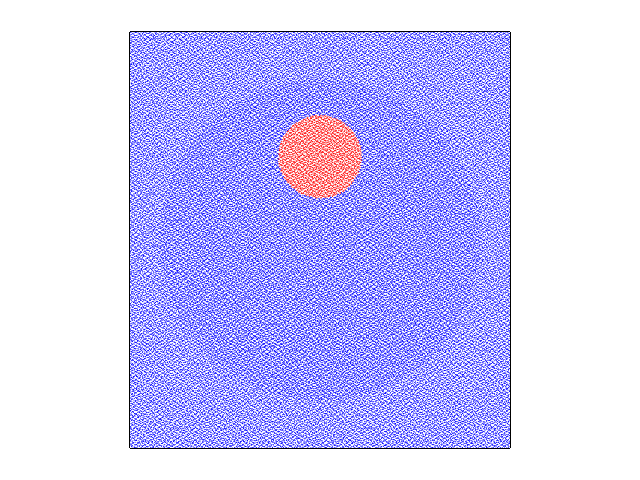

In [11]:
fig1 = plt.Figure()
fig1.Points( swarm=swarm, colourVariable=materialIndex, colours='blue red', colourBar = False, pointSize=2.0)
fig1.show()

Set up material parameters and functions
-----

Here the functions for density, viscosity are set using the ``map`` function. This function takes a key function (here the material index) and uses this key to the mapping dictionary to return a function for each particle in the swarm. 

For example if the material index of a particle is the light index number then the viscosity for that particle will be set to 1. If it had the heavy index number then it will be set to ``visc_sphere``, which can be either a function (say depending on temperature) or a constant as it is below.

The same approach is taken when setting up the density function for each particle in the swarm.

In [12]:
# set constants for the viscosity and density of the sinker
viscSphere = 10.0
densitySphere = 10.0

# Here we set a viscosity value of '1.' for both materials 
mappingDictViscosity = { materialLightIndex:1., materialHeavyIndex:viscSphere }
viscosityMapFn = fn.branching.map( keyFunc = materialIndex, mappingDict = mappingDictViscosity )
# Here we set a density of '0.' for the lightMaterial, and '1.' for the heavymaterial.
mappingDictDensity = { materialLightIndex:0., materialHeavyIndex:densitySphere }
densityFn      = fn.branching.map( keyFunc = materialIndex, mappingDict = mappingDictDensity )
# define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )
# now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
# The result from which will also be a FEvariable.
buoyancyFn = -densityFn * z_hat
# note the negative 

System setup
-----

**Setup a Stokes system**

In [13]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               swarm         = swarm, 
                               conditions    = [freeslipBC,],
                               viscosityFn   = viscosityMapFn, 
                               bodyForceFn   = buoyancyFn )

**Create an advective diffusive system**

In this case we specify second order integration for increased accuracy. The trade off for doing this is that it costs more computing time.

Note that we need to set up two advector systems, one for each particle swarm (our global swarm and the tracer particle).

In [14]:
advector  = uw.systems.SwarmAdvector( swarm=swarm,       velocityField=velocityField, order=2 )
advector2 = uw.systems.SwarmAdvector( swarm=tracerSwarm, velocityField=velocityField, order=2 )

Analysis tools
-----

**RMS velocity**

Set up integrals used to calculate the RMS velocity.

In [15]:
vdotv = fn.math.dot(velocityField,velocityField)
v2sum_integral  = uw.utils.Integral( feMesh=velocityMesh, fn=vdotv )
volume_integral = uw.utils.Integral( feMesh=velocityMesh, fn=1. )

Main simulation loop
-----

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.

Note that there are two ``advector.integrate`` steps, one for each swarm, that need to be done each time step.

In [16]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0
nsteps = 10
tTracer = np.zeros(nsteps)
xTracer = np.zeros(nsteps)
yTracer = np.zeros(nsteps)
# Perform 10 steps
while step<nsteps:
    # determine and store tracer location
    xTracer[step], yTracer[step] = tracerSwarm.particleCoordinates.data[0]
    tTracer[step] = time
    # Get solution for initial configuration
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size
    advector.integrate(dt)
    advector2.integrate(dt)
    # Calculate the RMS velocity
    vrms = math.sqrt( v2sum_integral.integrate()[0] / volume_integral.integrate()[0] )
    print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(step,time,vrms))

    # Increment
    time += dt
    step += 1


step =      0; time = 0.000e+00; v_rms = 9.147e-03
step =      1; time = 3.194e-01; v_rms = 9.192e-03
step =      2; time = 6.387e-01; v_rms = 9.260e-03
step =      3; time = 9.561e-01; v_rms = 9.311e-03
step =      4; time = 1.272e+00; v_rms = 9.353e-03
step =      5; time = 1.587e+00; v_rms = 9.401e-03
step =      6; time = 1.900e+00; v_rms = 9.438e-03
step =      7; time = 2.212e+00; v_rms = 9.513e-03
step =      8; time = 2.523e+00; v_rms = 9.564e-03
step =      9; time = 2.832e+00; v_rms = 9.601e-03


Post simulation analysis
-----

**Plot tracer particle**

Plot the vertical component of the tracer particle's position as a function of time.

Initial position: (0.457, 0.700)
Final position:   (0.457, 0.636)


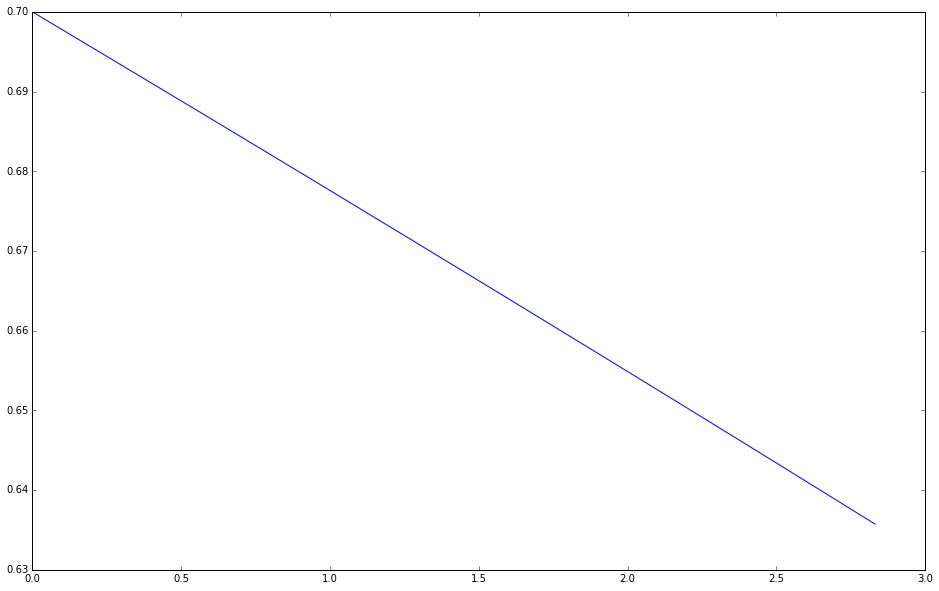

In [17]:
print('Initial position: ({0:.3f}, {1:.3f})'.format(xTracer[0], yTracer[0]))
print('Final position:   ({0:.3f}, {1:.3f})'.format(xTracer[nsteps-1], yTracer[nsteps-1]))

pylab.rcParams[ 'figure.figsize'] = 16, 10
pyplot.plot(tTracer, yTracer)
pyplot.show()

**Plot the final particle positions**

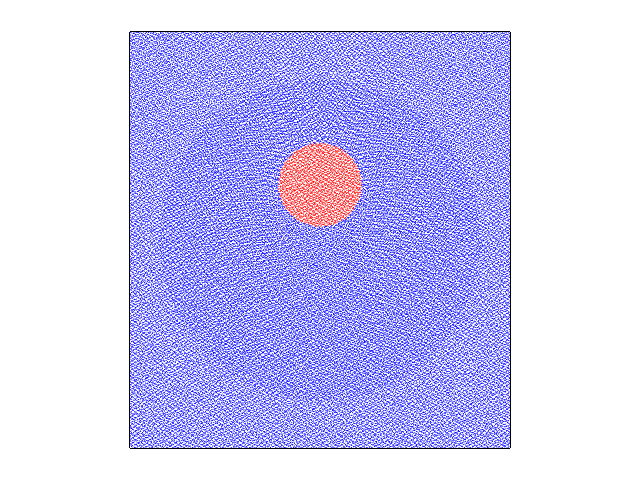

In [18]:
fig2 = plt.Figure()
fig2.Points( swarm=swarm, colourVariable=materialIndex, colours='blue red', colourBar = False, pointSize=2.0)
fig2.show()

**Plot velocity field**

Plot the velocity field in the fluid induced by the motion of the sinking ball.

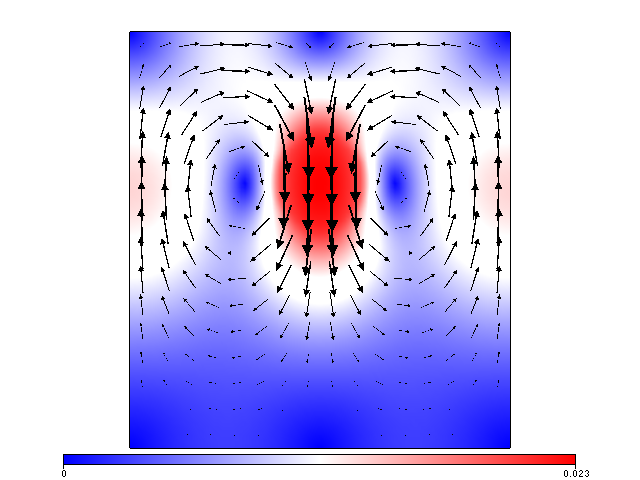

In [19]:
velplotmax=0.02
fig3 = plt.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot(velocityField,velocityField) )
fig3.VectorArrows( velocityField/(1.5*velplotmax), velocityMesh, arrowHeadSize=0.2, lengthScale=0.2 )
fig3.Surface( velmagfield, velocityMesh, colours="blue white red" )
fig3.show()

**Reading swarm data**

Examine the spatial coordinate data for the tracer swarm particle at the current time step.

In [20]:
print(tracerSwarm.particleCoordinates.data)

[[ 0.4571509   0.62859212]]
